In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import scipy as sc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [2]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()

In [4]:
inidate = '2022-02-14'
experiments = ['pi', 'curr', 'incr']
eps = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2no_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2no_2022-02-14.nc


# Select extreme and weak ensemble members

In [5]:
# box for selecting max wind gusts
full_map = [lon_min, lon_max, lat_min, lat_max]
fg10_box = full_map.copy()  #[-7, 2, 49, 54]  # lon_min, lon_max, lat_min, lat_max

In [38]:
members = {'extreme': [],
           'weak': []}
eps_extreme = []
eps_weak = []

for experiment in experiments:

    # select all time steps on the 18th but explicitly not just one to account for different peak times
    eps_feb18 = eps[experiment].sel(time='2022-02-18').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).squeeze()

    # select wind gusts within the boxes for each ensemble member
    eps_boxwinds = eps_feb18.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).fg10.squeeze()

    # calculate 95th percentile for each member wtihin the box
    fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude', 'time'])

    # select extreme and weak members based on being among the 10 strongest wind members 
    extremes = []
    for number in range(0,51):
        if (number in fg10_95.sortby(fg10_95).number.values[-10:]):
            extremes.append('wind')
        elif (number in fg10_95.sortby(fg10_95).number.values[:10]):
            extremes.append('low wind')
        else:
            extremes.append('none')
    
    extreme_members = pd.DataFrame(data = {'number':list(range(0,51)), 'fg10_95':fg10_95.values, 'extremes': extremes})
    
    members['extreme'].append(extreme_members[(extreme_members['extremes'].isin(['wind']))].number.values)
    members['weak'].append(extreme_members[(extreme_members['extremes'].isin(['low wind']))].number.values)
    eps_extreme.append(eps[experiment].sel(number = members['extreme'][-1]).squeeze())
    eps_weak.append(eps[experiment].sel(number = members['weak'][-1]).squeeze())

# Compositing 

## Time evolution in all experiments

In [40]:
time_steps = ['2022-02-16 12', '2022-02-17 12', '2022-02-18 06', '2022-02-18 12', '2022-02-18 18']

In [41]:
# Calculate significance for pi and incr maps
sign_test = {}
comp = eps['curr'].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean('number')
for exp in ['pi', 'incr']:
    map = eps[exp].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"])
    sign_test[exp] = xr.DataArray(sc.stats.binom((map>comp), 0.5).cdf((map>comp).sum('number')), coords=map.coords)

In [42]:
eps_extreme_mean = [x.sel(time = time_steps).mean(dim = 'number') for x in eps_extreme]
eps_weak_mean = [x.sel(time = time_steps).mean(dim = 'number') for x in eps_weak]

In [43]:
# calculate number of members in each composite
numbers = []
numbers.append([{'pi': eps_extreme[0].sizes['number'], # first dict for extreme composite
            'curr': eps_extreme[1].sizes['number'],
            'incr': eps_extreme[2].sizes['number']},
            
            {'pi': eps_weak[0].sizes['number'], # second dicts for weak composite
            'curr': eps_weak[1].sizes['number'],
            'incr': eps_weak[2].sizes['number']}])

In [44]:
# wind threshold exceedance
wind_threshold = 30

enscount_extreme_fg10 = [x.where(x.fg10 >= wind_threshold).count(dim = 'number').squeeze() for x in eps_extreme]
enscount_weak_fg10 = [x.where(x.fg10 >= wind_threshold).count(dim = 'number').squeeze() for x in eps_weak]

In [45]:
# projection = ccrs.PlateCarree()
# p_max = 1040
# p_min = 960

# fg10_min = 20
# fg10_max = 40

# # fg10_min = 0
# # fg10_max = 1

# longitude = eps_weak[0].longitude.values
# latitude = eps_weak[0].latitude.values
# wind_threshold_cases = [enscount_extreme_fg10, enscount_weak_fg10]
# full_eps_composite_cases = [eps_extreme, eps_weak]


# for e, experiment in enumerate(experiments):
#     for c, case in enumerate([eps_extreme_mean, eps_weak_mean]): 
#         for t, time in enumerate(eps_weak_mean[0].time):

#             fg10_vals = case[e].sel(time = time).fg10.values  # wind averages
#             # fg10_vals = wind_threshold_cases[c][e].sel(time = time).fg10.values/numbers[i][c][experiment]  # wind threshold exceedance
#             p_vals = case[e].sel(time = time).msl.values/100  # divide by 100 for Pa to hPa

#             # figure and map setup
#             fig = plt.figure(1, figsize=(40, 10))
#             ax = plt.subplot(2,len(time_steps),int(c*len(time_steps)+t+1), projection = projection)
#             ax.set_extent([lon_min-13, lon_max, lat_min-5, lat_max+6], projection)
#             ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

#             # fg10 as shading
#             clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
#             cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
#                             transform=projection)

#             # isobars as contours
#             clevs_p = np.linspace(p_min, p_max, 17) 
#             cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
#                             transform=projection)
#             plt.clabel(cs, fmt='%d')
#             ax.set_title(experiment+" ,time = " + str(time.values)[:16])

#             # dots for pressure minimum
#             dummy = full_eps_composite_cases[c][e].sel(time=time, latitude=slice(lat_max+6,lat_min-5), longitude=slice(lon_min-13,lon_max)).msl
#             min_pres_loc = dummy.isel(dummy.argmin(dim=["latitude", "longitude"]))
#             ax.scatter(min_pres_loc.longitude, min_pres_loc.latitude, marker = 'x', s = 50, c = 'r')

#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#     fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)')

#     # plt.savefig('figures/07_composite_averages_time_evolution_'+experiment+'_inidate_'+inidate+'.png')
#     # plt.savefig('figures/07_composite_averages_time_evolution_'+experiment+'_inidate_'+inidate+'.pdf')
#     plt.show()
        

## Friday 12UTC comparison of experiments

In [46]:
eps_extreme_mean = [x.sel(time = '2022-02-18 12').mean(dim = 'number') for x in eps_extreme]
eps_weak_mean = [x.sel(time = '2022-02-18 12').mean(dim = 'number') for x in eps_weak]

In [47]:
# projection = ccrs.PlateCarree()
# p_max = 1040
# p_min = 960

# fg10_min = 20
# fg10_max = 50

# longitude = eps_weak[0].longitude.values
# latitude = eps_weak[0].latitude.values

# time = eps_extreme_mean[0].time
# for e, experiment in enumerate(['pi', 'curr', 'incr']):
#     for c, case in enumerate([eps_extreme_mean, eps_weak_mean]):    
#         fg10_vals = case[e].fg10.values[:,:]
#         p_vals = case[e].msl.values[:,:]/100

#         # figure and map setup
#         fig = plt.figure(1, figsize=(20, 10))
#         ax = plt.subplot(2,3,int(e+c*3+1), projection = projection) # TODO fix indices
#         ax.set_extent([lon_min-13, lon_max, lat_min-5, lat_max+6], projection)
#         ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

#         # fg10 as shading
#         clevs_fg10 = np.linspace(fg10_min, fg10_max, 17)
#         cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
#                         transform=projection)

#         #isobars as contours
#         clevs_p = np.linspace(p_min, p_max, 17)
#         cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
#                         transform=projection)
#         plt.clabel(cs, fmt='%d')
#         ax.set_title(experiment+", time = " + str(time.values)[:16])

#         # dots for pressure minimum
#         dummy = full_eps_composite_cases[c][e].sel(time=time, latitude=slice(lat_max+6,lat_min-5), longitude=slice(lon_min-13,lon_max)).msl
#         min_pres_loc = dummy.isel(dummy.argmin(dim=["latitude", "longitude"]))
#         ax.scatter(min_pres_loc.longitude, min_pres_loc.latitude, marker = 'x', s = 50, c = 'r')

#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#     fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)')

# # plt.savefig('figures/07_composite_averages_2022-02-18T12_inidate'+inidate+'.png')
# # plt.savefig('figures/07_composite_averages_2022-02-18T12_inidate'+inidate+'.pdf')

# Maximum wind gusts

In [48]:
eps_extreme_dict = {'pi': eps_extreme[0], 'curr': eps_extreme[1], 'incr': eps_extreme[2]}

In [49]:
maximum_gusts_eps = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict.items()}
minimum_pres_eps = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).msl.min(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict.items()}
mean_pres_eps = {key:value.sel(time = '2022-02-18 12').msl.mean(dim = "number") for (key,value) in eps_extreme_dict.items()}

In [50]:
maximum_gusts_era5 = era5_GUST.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim = ["time"])
minimum_pres_era5 = era5_PRES.sel(time = slice('2022-02-18 00', '2022-02-18 23')).min(dim = ["time"])
mean_pres_era5 = era5_PRES.sel(time = '2022-02-18 12')

In [51]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


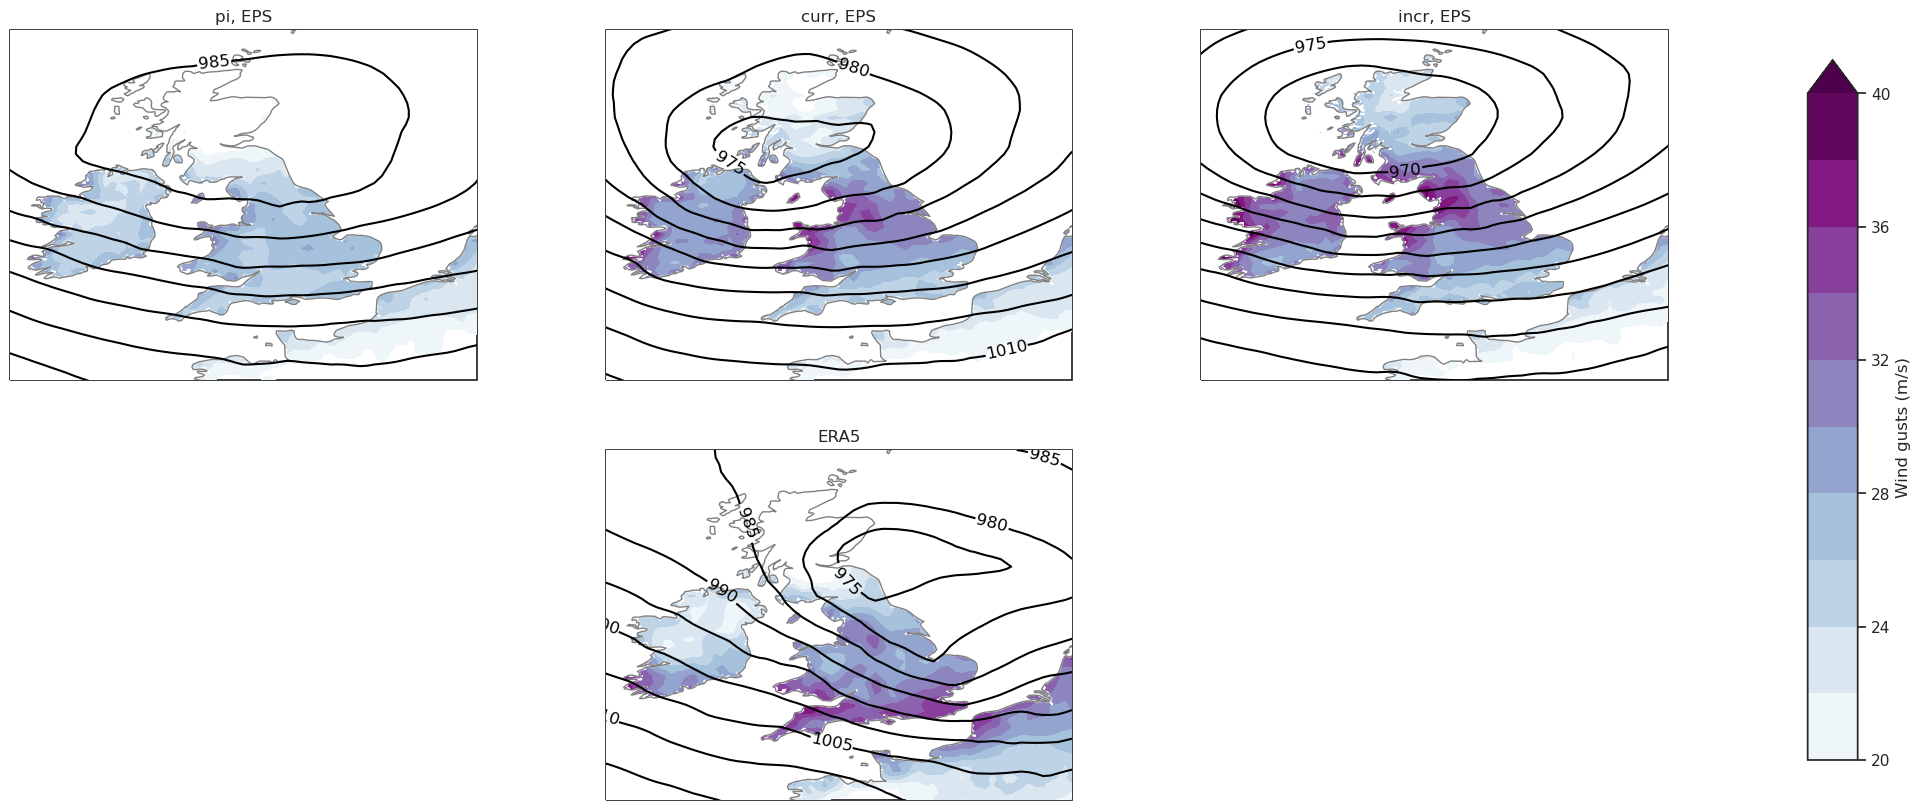

In [52]:
# figure and map setup
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 40

fig = plt.figure(1, figsize=(25, 10))

# EPS data ------------------    
latitude = mean_pres_eps['pi'].latitude
longitude = mean_pres_eps['pi'].longitude

for e, experiment in enumerate(experiments):
    p_vals = mean_pres_eps[experiment].values/100
    fg10_vals = maximum_gusts_eps[experiment].values

    ax = plt.subplot(2,3,e+1,projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

    # fg10 as shading
    clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection, zorder = 10, extend = 'max')

    # isobars as contours
    clevs_p = np.linspace(p_min, p_max, 17) 
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection, zorder = 16)
    plt.clabel(cs, fmt='%d')
    ax.set_title(experiment+", EPS")


# ERA5 data ----------------------
latitude = mean_pres_era5.latitude
longitude = mean_pres_era5.longitude

p_vals = mean_pres_era5.values/100
fg10_vals = maximum_gusts_era5.values
ax = plt.subplot(2,3,5,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17) 
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax.set_title("ERA5")


# Other figure settings -----------------
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')

plt.savefig('figures/07_composite_maximum_gusts_inidate'+inidate+'.png')
plt.savefig('figures/07_composite_maximum_gusts_inidate'+inidate+'.pdf')

# Poster figure

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


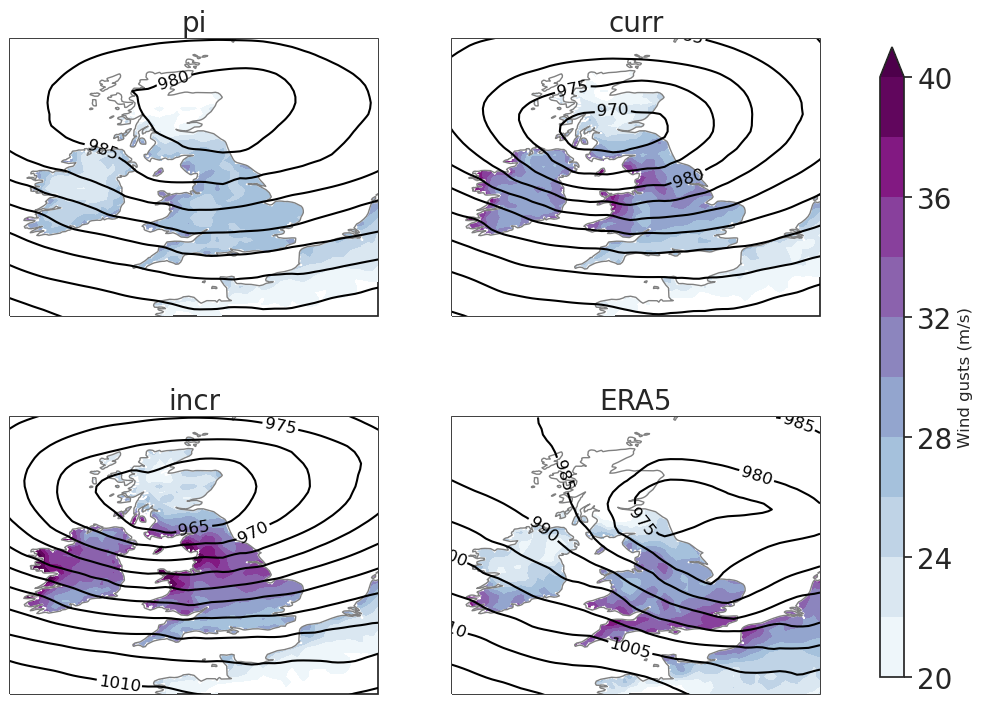

In [19]:
# figure and map setup
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 40

fig = plt.figure(1, figsize=(12, 9))

# EPS data ------------------    
latitude = mean_pres_eps['pi'].latitude
longitude = mean_pres_eps['pi'].longitude

for e, experiment in enumerate(experiments):
    p_vals = mean_pres_eps[experiment].values/100
    fg10_vals = maximum_gusts_eps[experiment].values

    ax = plt.subplot(2,2,e+1,projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

    # fg10 as shading
    clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection, zorder = 10, extend = 'max')
    
    # isobars as contours
    clevs_p = np.linspace(p_min, p_max, 17) 
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection, zorder = 16)
    plt.clabel(cs, fmt='%d')
    ax.set_title(experiment, size = '20')

# ERA5 data ----------------------
latitude = mean_pres_era5.latitude
longitude = mean_pres_era5.longitude

p_vals = mean_pres_era5.values/100
fg10_vals = maximum_gusts_era5.values
ax = plt.subplot(2,2,4,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17) 
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax.set_title("ERA5", size = 20)


# Other figure settings -----------------
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')
cbar_ax.tick_params(labelsize = 20)

plt.savefig('figures/07_poster_maxwinds'+inidate+'.png')
plt.savefig('figures/07_poster_maxwinds'+inidate+'.pdf')